In [25]:
# IMPORTS

import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import tensorflow
import lightkurve as lk
import cv2
import io

from PIL import Image

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

import astropy
from astropy.timeseries import TimeSeries


In [19]:
# FOLDERS AND DIRECTORIES

lc_train_folder = "./lightcurvePLOTS/" # create one for lightcurves with no exoplanets
lc_train_dir = os.listdir(lc_train_folder)
lc_exo_plots = "./lightcurvePLOTS/has_exoplanets/"
lc_fa_plots = "./lightcurvePLOTS/no_exoplanets/" # false alarms

In [20]:
# PHASE AND BIN FUNCTION

def phase_and_bin(data,period,t0,bin_time):
    data_phased = data.fold(period=period,epoch_time=t0)
    data_binned = data_phased.bin(bin_time)
    return data_binned


In [21]:
# CONVERT PLOT TO ARRAY FUNCTION

def plot_to_array(pltdata):

    px = 1/plt.rcParams["figure.dpi"] # gets pixel unit

    fig = plt.figure(figsize=(432*px,288*px),dpi=128)

    pltdata.plot(linewidth=0,marker=".")

    io_buf = io.BytesIO()
    fig.savefig(io_buf,format="raw",dpi=128)
    io_buf.seek(0)
    img_arr = np.frombuffer(io_buf.getvalue(),dtype=np.uint8)
    im = img_arr.reshape(int(fig.bbox.bounds[3]),int(fig.bbox.bounds[2]),-1) # reshapes np image array into image dimensions
    io_buf.close()
    
    return im

In [ ]:
# READ ARRAY AS IMAGE

def read_img_array(img_array):
    img = np.asarray(bytearray(img_array.read()),dtype="uint8")
    img = cv2.imdecode(img,cv2.IMREAD_COLOR)
    cv2.imwrite("result.png",img)

TIC 72437047


/home/vanillacosmos/miniconda3/envs/codeastrogit/lib/python3.9/site-packages/lightkurve/lightcurve.py:1039: LightkurveWarning: `epoch_time` appears to be given in JD, however the light curve time uses BTJD (i.e. JD - 2457000).
  warnings.warn(


error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'imdecode'
> Overload resolution failed:
>  - buf is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'buf'


<Figure size 768x512 with 0 Axes>

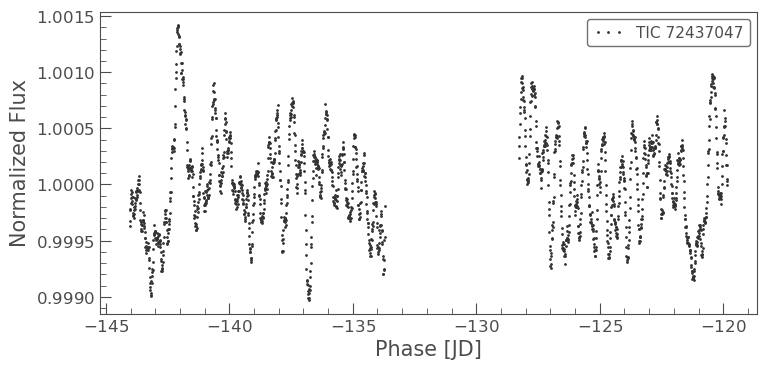

In [28]:
# FETCH DATA (TESS DATA W/ LIGHTKURVE)

exonames_tbl = pd.read_csv(os.path.abspath("PS_2022.06.27_08.12.38.csv"),delimiter=",",comment="#")
TICs = exonames_tbl["tic_id"]
periods = exonames_tbl["pl_orbper"] # for phasing
epochs = exonames_tbl["pl_orbtper"] # for phasing

bintime = 15/24/60

exotrainimgs = []

for x in range(0,17):
    print(TICs[x])
    name = TICs[x]
    if np.isnan(periods[x]) == False and np.isnan(epochs[x]) == False:
        train_exo_search = lk.search_lightcurve(str(name),author="SPOC")[0:5]
        lc_exo_train = train_exo_search.download_all().stitch()
        
        lc_exo_train_binned = phase_and_bin(lc_exo_train,periods[x],epochs[x],bintime)
        
        img = plot_to_array(lc_exo_train_binned)
        

In [ ]:
fa_tbl = pd.read_csv(os.path.abspath("TOI_2022.06.29_08.07.35.csv"),delimiter=",",comment="#")
fa_TICs = fa_tbl["tid"]

y = 0

while y < len(fa_TICs):
    name1 = fa_TICs[y]
    try:
        train_fa_search = lk.search_lightcurve("TIC " + str(name1),author="SPOC",sector=1)
        lc_fa_train = train_fa_search.download()
        plot_to_array(lc_fa_train)
    except:
        train_fa_search = lk.search_lightcurve("TIC " + str(name1),author="TESS",sector=1)
        lc_fa_train = train_fa_search.download()
        plot_to_array(lc_fa_train)
    else:
        print("No lightcurve found.")
    
    y = y + 1

In [ ]:
# USER INPUT TARGET STAR AND MISSION

target = str(input("Enter your target: "))
mission = str(input("Enter mission: "))
quart = input("Enter quarter (Kepler) or sector (TESS), A for all, M for multiple: ")

In [ ]:
# FIND, PLOT AND SAVE TEST DATA

test_plot_dir = "./testPLOTS/"

if quart == "A" or quart == "a" or quart == "all" or quart == "All":
    testsearch = lk.search_lightcurve(target,author=mission)
    lc_test = testsearch.download()

elif quart == "M":
    q1 = int(input("Enter first quarter/sector: "))
    q2 = int(input("Enter last quarter/sector: "))
    testsearch = lk.search_lightcurve(target,author=mission)[q1:q2]
    lc_test = testsearch.download_all().stitch()

else:
    if mission == "Kepler":
        testsearch = lk.search_lightcurve(target,author=mission,quarter=int(quart))
    elif mission == "SPOC":
        testsearch = lk.search_lightcurve(target,author=mission,sector=int(quart))
    lc_test = testsearch.download()

period = 83.8979
t0 = 2125.847

lc_test_binned = phase_and_bin(lc_test,period,t0,bintime)

plot_to_array(lc_test_binned)

In [ ]:
# CREATE TRAIN AND TEST DATASETS

train = ImageDataGenerator(rescale=1/255)
test = ImageDataGenerator(rescale=1/255)
batchsize = 7
trainplots = "./lightcurvePLOTS/"

train_ds = train.flow_from_directory(
    os.path.abspath(trainplots),
    target_size=(150,150),
    batch_size = batchsize,
    class_mode = 'binary')

test_ds = test.flow_from_directory(
    os.path.abspath(test_plot_dir),
    target_size=(150,150),
    batch_size = batchsize,
    class_mode = 'binary')

# BUILD CNN MODEL

model = keras.Sequential()

model.add(keras.layers.Conv2D(32,(3,3),activation="relu",input_shape=(150,150,3)))
model.add(keras.layers.MaxPool2D(2,2))

model.add(keras.layers.Conv2D(64,(3,3),activation="relu"))
model.add(keras.layers.MaxPool2D(2,2))

model.add(keras.layers.Conv2D(128,(3,3),activation="relu"))
model.add(keras.layers.MaxPool2D(2,2))

model.add(keras.layers.Conv2D(128,(3,3),activation="relu"))
model.add(keras.layers.MaxPool2D(2,2))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(512,activation="relu"))

model.add(keras.layers.Dense(1,activation="sigmoid"))

model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

# TRAIN DATA

model.fit(
    train_ds,
    steps_per_epoch = 250,
    epochs = 10,
    validation_data = test_ds
)

# PREDICTIONS (FUNCTION)

def predictExo(filename):
    img = image.load_img(filename,target_size=(150,150))
    plt.imshow(img)

    Y = image.img_to_array(img)
    X = np.expand_dims(Y,axis=0)

    val = model.predict(X)
    print(val)

    if val == 1:
        plt.xlabel("Exoplanet detected!",fontsize=30)
    elif val == 0:
        plt.xlabel("No exoplanet detected.",fontsize=30)

predictExo(os.path.join(os.path.abspath(test_plot_dir),"valid_exoplanets","lc_testplot.png"))